In [ ]:
import os
import pickle
import nltk
import sys
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.backend import languages
import streamlit as st


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

script_dir = os.path.dirname(os.path.abspath('__file__'))
print("Script directory:", script_dir)
multilingual_dir = os.path.join(script_dir, 'MULTILINGUAL')
sys.path.append(multilingual_dir)
print(f"Added {multilingual_dir} to Python path")

from multiling_helpers import JapaneseProcessor, TopicModeler

In [ ]:


# ------------------------------------------------------------------------------------------------
# SET PARAMS FOR DATASET
# ------------------------------------------------------------------------------------------------

project = "multilingual"
dataset = "innerspeech" 
language = "japanese"


#check that chosen language is supported by BERTopic internal language
if language not in languages:
    raise ValueError(f"Language '{language}' is not supported. Supported languages are: {languages}")

DATA_dir = os.path.join(script_dir, f'DATA/{project}/{language}/{dataset}')
print("DATA directory:", DATA_dir)

cache_dir = os.path.join(DATA_dir, "cache")
print("Cache directory:", cache_dir)
print(f"Files in cache directory: {os.listdir(cache_dir)}")



DATA directory: /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech
Cache directory: /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/cache
Files in cache directory: ['innerspeech_processed_data.pkl']


In [19]:
# *********** /!\ *********** #
delete_cache_data = True
delete_cache_embeddings = True
delete_cache_labels = True
merge_reports = False
# *********** /!\ *********** #

prefix = "merged_" if merge_reports else ""
cache_prefix = f"{prefix}{dataset}"

#cache paths
embeddings_cache_path = os.path.join(cache_dir, f"{cache_prefix}_embeddings.pkl")
data_cache_path = os.path.join(cache_dir, f"{cache_prefix}_processed_data.pkl")
llama_labels_path = os.path.join(cache_dir, f"{dataset}_llama_labels.pkl")

# Delete caches if requested
if delete_cache_data and os.path.exists(data_cache_path):
    os.remove(data_cache_path)
    print(f"Deleted cached processed data: {data_cache_path}")
    
if delete_cache_embeddings and os.path.exists(embeddings_cache_path):
    os.remove(embeddings_cache_path)
    print(f"Deleted cached embeddings: {embeddings_cache_path}")

if delete_cache_labels and os.path.exists(llama_labels_path):
    os.remove(llama_labels_path)
    print(f"Deleted cached labels: {llama_labels_path}")

print(f"Files in cache directory: {os.listdir(cache_dir)}")



Files in cache directory: []


In [20]:
# Initialize Japanese processor and topic modeler (defined in multiling_helpers.py)
japanese_processor = JapaneseProcessor()
japanese_processor.sentence_transformer_model = "sonoisa/sentence-bert-base-ja-mean-tokens" #"paraphrase-multilingual-mpnet-base-v2"
japanese_modeler = TopicModeler(japanese_processor,use_stopwords=True) #init modeler with modified processor
japanese_processor.print_info()

No sentence-transformers model found with name sonoisa/sentence-bert-base-ja-mean-tokens. Creating a new one with mean pooling.


Language: japanese
Transformer model: sonoisa/sentence-bert-base-ja-mean-tokens
Number of stopwords: 38
Sentence endings: {'。', '?', '\n', '？', '!', '！', '.', '．'}


In [21]:
#load data from /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/innerspeech_japanese_reports.pkl
#data = pd.read_pickle(os.path.join(DATA_dir, f"{dataset}_reports.pkl"))
data = pd.read_pickle(os.path.join(DATA_dir, f"{dataset}_reports.pkl"))
data

['頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。',
 '他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）',
 '頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。\n映像や味などは思い出される事がある。',
 '自動思考というものなのか、直近で起きた失敗などを批判する考えが勝手に浮かんできたりすることがあるが、自分の声とか他人の声という認識はしていなかった。',
 '食べたいもの、欲しいものなどは、自分がそれを食べている、或いは使っているところを想像して決めているような感じでした。逆に、どこに置いたかな、というのは「自分が置いたときのイメージが湧かないからこそそういう状況になっている」ときは言葉で、「場面を辿ればわかる」ときは映像で思い浮かぶ感じでした。\n発達系の話になりますが視覚優位か聴覚優位かなどによっても変わりそうで面白いなと思いました。',
 '画像や映像が頭の中に流れ、その後に自分の声で考える事が多い。',
 'フローチャートや箇条書きで考えるのは便利そうなので意識的にやってみたい。',
 'キャスト全員が自分の声で話しているボイスドラマを聴いている風に内言します。',
 '思考中にふと反対意見・対立意見が他人の声で聞こえる',
 '言葉にできないことが多い。説明や言葉が足りず、内容を人に理解させることが難しい。',
 'この度は面白いテーマでのアンケートの機会をいただきありがとうございます。アンケートを通じて改めて、黙読している時も、文章を書いている時も必ず内言が生じていることに気づきました。アンケートの内容からそうではない人がいるのだということも知ることができ、大変面白くもありました。',
 '五感のどれをどのくらい使うかは、場合による。',
 'イメージだけを提示する別の自分と会話している感じはする',
 '全体的に「言われてみればこう

In [22]:
processed_data = japanese_modeler.process_data(data, split_sentences=True)
#save to 

if not os.path.exists(data_cache_path):
    with open(data_cache_path, 'wb') as f:
        pickle.dump(processed_data, f)
    print(f"Processed data saved to {data_cache_path}")

Processed data saved to /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/cache/innerspeech_processed_data.pkl


In [23]:
# Load cached data
if os.path.exists(data_cache_path):
    print("Loading cached processed data...")
    with open(data_cache_path, "rb") as f:
        processed_data = pickle.load(f)
    print(f"Loaded data with {len(processed_data)} sentences")
else:
    print("No cached data found. Please run the preprocessing script first.")

processed_data[0][:10] #check the firdt 10 sentences


Loading cached processed data...
Loaded data with 2 sentences


['頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。',
 '他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？',
 '（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）',
 '頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。',
 '映像や味などは思い出される事がある。',
 '自動思考というものなのか、直近で起きた失敗などを批判する考えが勝手に浮かんできたりすることがあるが、自分の声とか他人の声という認識はしていなかった。',
 '食べたいもの、欲しいものなどは、自分がそれを食べている、或いは使っているところを想像して決めているような感じでした。',
 '逆に、どこに置いたかな、というのは「自分が置いたときのイメージが湧かないからこそそういう状況になっている」ときは言葉で、「場面を辿ればわかる」ときは映像で思い浮かぶ感じでした。',
 '発達系の話になりますが視覚優位か聴覚優位かなどによっても変わりそうで面白いなと思いました。',
 '画像や映像が頭の中に流れ、その後に自分の声で考える事が多い。']

In [16]:
# Load cached embeddings
if not delete_cache_embeddings and os.path.exists(embeddings_cache_path):
    print("Loading cached embeddings...")
    with open(embeddings_cache_path, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded embeddings with shape: {embeddings.shape}")
else:
    print("No cached embeddings found. Running the embeddings...")
    print(f"Generating embeddings for {len(processed_data)} sentences...")
    japanese_embedder = SentenceTransformer(japanese_processor.sentence_transformer_model)
    embeddings = japanese_embedder.encode(processed_data, show_progress_bar=True)
    print(f"Generated embeddings with shape: {embeddings.shape}")
    with open(embeddings_cache_path, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved embeddings to {embeddings_cache_path}")



No cached embeddings found. Running the embeddings...
Generating embeddings for 2 sentences...


No sentence-transformers model found with name sonoisa/sentence-bert-base-ja-mean-tokens. Creating a new one with mean pooling.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (2, 768)
Saved embeddings to /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/cache/innerspeech_embeddings.pkl


In [12]:



# Set up clustering components
umap_model = UMAP(
    n_neighbors=10,
    n_components=5, #default to 5
    min_dist=0.01,
    metric='cosine',
    low_memory=False,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10, #default to 10
    min_samples=10,
    # cluster_selection_epsilon=0.2,
    # cluster_selection_method='leaf',
    gen_min_span_tree=True,
    prediction_data=True
)


In [13]:

print("Training BERTopic model...")
base_topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    language="japanese",
    # nr_topics="auto",
    calculate_probabilities=True,
    verbose=True
)

topics, probs = base_topic_model.fit_transform(processed_data, embeddings)

total_topics = len(set(base_topic_model.topics_))
print(f"Total number of topics (including outlier topic): {total_topics}")

topic_info = base_topic_model.get_topic_info()
print(f"Number of topics found: {len(topic_info)-1}")  # -1 to exclude outlier topic

topic_info.head(10)


2025-04-09 13:48:33,723 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Training BERTopic model...


2025-04-09 13:48:42,049 - BERTopic - Dimensionality - Completed ✓
2025-04-09 13:48:42,050 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-09 13:48:42,160 - BERTopic - Cluster - Completed ✓
2025-04-09 13:48:42,162 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-09 13:48:42,185 - BERTopic - Representation - Completed ✓


Total number of topics (including outlier topic): 27
Number of topics found: 26


,Topic,Count,Name,Representation,Representative_Docs
0,-1,822,-1_また_内言_しかし_映像,"[また, 内言, しかし, 映像, 自分の声, など, 自分の場合は, たとえば, そのため...","[また、感覚としては②も“聞こえてこない”に該当しています。, 物事について考えたり、アイデ..."
1,0,129,0_感覚_映像_avkテスト_検討中,"[感覚, 映像, avkテスト, 検討中, 画像や動画のような, 概ね静止画だが細かく思い出...","[映像（短い動画・静止映像）もぼんやり映りますが、主に言語（自分の声）で考えます。, ・そう..."
2,1,101,1_18歳くらいまでは複数の人格が会話するような内言が多かった_小言_感嘆だったりツッコミだ...,"[18歳くらいまでは複数の人格が会話するような内言が多かった, 小言, 感嘆だったりツッコミ...",[子供の頃（小学生くらいのころ）はもっとたくさんの内言が頭の中に（すべて自分で、自分の声だが...
3,2,78,2_内言_なので_1人で思考したり行動したりする時に内言が増えると思いました_感情はキャンバ...,"[内言, なので, 1人で思考したり行動したりする時に内言が増えると思いました, 感情はキャ...",[改めて考えてみると、私に独り言が非常に多いのは、内言が多くて脳がつかれるから、ある程度口か...
4,3,66,3_1人で過ごす時_夢を見ている時などは他人の声もかなり正確に再現することが出来たり_夜寝る...,"[1人で過ごす時, 夢を見ている時などは他人の声もかなり正確に再現することが出来たり, 夜寝...","[口に出さない独り言だったり、気づいたら記憶を遡ってたり、妄想してたり、色々あります。, な..."
5,4,61,4_あなたはどう考えた_困ると思考が止まって_自分の考えていることなのにどうやって自分以外の...,"[あなたはどう考えた, 困ると思考が止まって, 自分の考えていることなのにどうやって自分以外...","[言葉で考えられることと言葉で考えられないこと(図形など)で思考方法が異なります。, アンケ..."
6,5,59,5_写真_食べたいもの_対して_財布,"[写真, 食べたいもの, 対して, 財布, 映像, 例えば, しかし, 料理名を頭の中で読み...",[日常で「食べたいもの」を考える時は、頭の中で食べ物の映像と味が想像され、私の感情がそれを気...
7,6,52,6_研究がんばってください_とても興味深いです_研究頑張ってください_ありがとうございました,"[研究がんばってください, とても興味深いです, 研究頑張ってください, ありがとうございま...","[とても興味深いです！, 研究がんばってください！, とても興味深いです。]"
8,7,46,7_いまこの文を打ち込んでいるときも_小説を書く時は_解釈違い_本をどうやって読むか,"[いまこの文を打ち込んでいるときも, 小説を書く時は, 解釈違い, 本をどうやって読むか, ...",[書き上がった文章を読んで、初めて「内言と思考の違いについて伝えておきたかったのだ」と分かる...
9,8,45,8_すみません_もある_という気もしますが_などと言うようにいつもの口調です,"[すみません, もある, という気もしますが, などと言うようにいつもの口調です, このアン...","[すみません。, すみません。, すみません…。]"


In [14]:
# Coherence score calculation

try:
    src_path = os.path.join(MOSAIC_dir, "src")
    sys.path.insert(0, src_path)
    from utils import calculate_coherence
    
    # Calculate coherence for base model
    coherence_score, coherence_score_umass = calculate_coherence(base_topic_model, processed_data)
    print(f"Coherence Score: {coherence_score:.4f}")
    print(f"UMass Coherence Score: {coherence_score_umass:.4f}")
    
except (ImportError, Exception) as e:
    print(f"Coherence calculation skipped: {str(e)}")

Coherence calculation skipped: name 'MOSAIC_dir' is not defined


In [17]:
# Count number of sentences per topic
topic_counts = pd.Series(topics).value_counts().sort_index()
total_docs = len(topics)

print("Number of sentences per topic:")
for topic_id, count in topic_counts.items():
    percentage = (count / total_docs) * 100
    if topic_id == -1:
        print(f"Outliers (Topic -1): {count} sentences ({percentage:.1f}%)")
    else:
        print(f"Topic {topic_id}: {count} sentences ({percentage:.1f}%)")

Number of sentences per topic:
Outliers (Topic -1): 822 sentences (44.5%)
Topic 0: 129 sentences (7.0%)
Topic 1: 101 sentences (5.5%)
Topic 2: 78 sentences (4.2%)
Topic 3: 66 sentences (3.6%)
Topic 4: 61 sentences (3.3%)
Topic 5: 59 sentences (3.2%)
Topic 6: 52 sentences (2.8%)
Topic 7: 46 sentences (2.5%)
Topic 8: 45 sentences (2.4%)
Topic 9: 40 sentences (2.2%)
Topic 10: 37 sentences (2.0%)
Topic 11: 32 sentences (1.7%)
Topic 12: 29 sentences (1.6%)
Topic 13: 25 sentences (1.4%)
Topic 14: 24 sentences (1.3%)
Topic 15: 23 sentences (1.2%)
Topic 16: 23 sentences (1.2%)
Topic 17: 23 sentences (1.2%)
Topic 18: 23 sentences (1.2%)
Topic 19: 21 sentences (1.1%)
Topic 20: 20 sentences (1.1%)
Topic 21: 17 sentences (0.9%)
Topic 22: 13 sentences (0.7%)
Topic 23: 13 sentences (0.7%)
Topic 24: 12 sentences (0.7%)
Topic 25: 12 sentences (0.7%)


In [15]:
topic_info = base_topic_model.get_topic_info() #update topic info after outleir reduction
print("\nTop topics by size (excluding outliers):")
print(topic_info.head())


Top topics by size (excluding outliers):
   Topic  Count                                               Name  \
0     -1    822                                    -1_また_内言_しかし_映像   
1      0    129                                 0_感覚_映像_avkテスト_検討中   
2      1    101  1_18歳くらいまでは複数の人格が会話するような内言が多かった_小言_感嘆だったりツッコミだ...   
3      2     78  2_内言_なので_1人で思考したり行動したりする時に内言が増えると思いました_感情はキャンバ...   
4      3     66  3_1人で過ごす時_夢を見ている時などは他人の声もかなり正確に再現することが出来たり_夜寝る...   

                                      Representation  \
0  [また, 内言, しかし, 映像, 自分の声, など, 自分の場合は, たとえば, そのため...   
1  [感覚, 映像, avkテスト, 検討中, 画像や動画のような, 概ね静止画だが細かく思い出...   
2  [18歳くらいまでは複数の人格が会話するような内言が多かった, 小言, 感嘆だったりツッコミ...   
3  [内言, なので, 1人で思考したり行動したりする時に内言が増えると思いました, 感情はキャ...   
4  [1人で過ごす時, 夢を見ている時などは他人の声もかなり正確に再現することが出来たり, 夜寝...   

                                 Representative_Docs  
0  [また、感覚としては②も“聞こえてこない”に該当しています。, 物事について考えたり、アイデ...  
1  [映像（短い動画・静止映像）もぼんやり映りますが、主に言語（自分の声）で考えます。, ・そう...  
2  [子供の頃（小学生くらいのころ）はもっとたくさんの内言が頭の中に

In [16]:
reduced_embeddings = UMAP(
    n_neighbors=10, 
    n_components=2, 
    min_dist=0.01, 
    random_state=42
).fit_transform(embeddings)

print(f"Shape of reduced embeddings: {reduced_embeddings.shape}")


Shape of reduced embeddings: (1846, 2)


In [20]:
base_barchart = base_topic_model.visualize_barchart(
    title=f'Topic Word Scores for {dataset} (Base Model)',
    autoscale=True
)

base_docs_vis = base_topic_model.visualize_documents(
    docs=processed_data,
    reduced_embeddings=reduced_embeddings,
    title=f'Documents and Topics for {dataset} (Base Model)',
    hide_annotations=True
)

hierarchy_vis = base_topic_model.visualize_hierarchy(
    color_threshold=0.8
)

base_docs_vis

In [25]:
# Delete the cached LLM labels if they exist
delete_LLM_cache = True
if delete_LLM_cache:
    llama_labels_path = os.path.join(cache_dir, f"{dataset}_llama_labels.pkl")
    if os.path.exists(llama_labels_path):
        import os
        os.remove(llama_labels_path)
        print(f"Deleted cached LLM labels: {llama_labels_path}")

    # Generate new LLM topic interpretations using Llama-3
    print("Loading LLM model for topic labeling...")

Deleted cached LLM labels: /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/cache/innerspeech_japanese_llama_labels.pkl
Loading LLM model for topic labeling...


In [26]:
# check if we have cached labels previously saved
llama_labels_path = os.path.join(cache_dir, f"{dataset}_llama_labels.pkl")
if os.path.exists(llama_labels_path):
    print("Checking for previously cached LLM labels...")
    with open(llama_labels_path, "rb") as f:
        topic_labels = pickle.load(f)
    print("Loaded previously cached LLM labels.")

else:
    from huggingface_hub import hf_hub_download
    from llama_cpp import Llama
    from bertopic.representation import LlamaCPP
    import re
    
    print("Loading LLM model for topic labeling...")
    
    model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
    model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
    model_cache_dir = os.path.join('models', f"{model_name_or_path.replace('/', '_')}")  # Cache directory for the model
    
    #check if model exists already in cache
    model_path = os.path.join(model_cache_dir, model_basename)
    if os.path.exists(model_path):
        print("Model already downloaded. Using cached model...")
    else:
        # download model
        print("Downloading LLM...")
        os.makedirs(model_cache_dir, exist_ok=True)        
        model_path = hf_hub_download(
            repo_id=model_name_or_path, 
            filename=model_basename, 
            cache_dir=model_cache_dir
        )

Loading LLM model for topic labeling...


Loading LLM model for topic labeling...


llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

Topic -1: Thought Process A
Topic 0: Visual Imagery B
Topic 1: Inner Monologue Your task
Topic 2: 自動思考 Q
Topic 3: Inner Monologue Your code here
Topic 4: Thought Process B
Topic 5: Food Selection Process Your code here
Topic 6: Research Support 2 Text
Topic 7: Reading and Writing B
Topic 8: Q
Topic 9: Inner Voice Experience Your code here
Topic 10: Inner Voice Your code here
Topic 11: Inner Speech Patterns Q
Topic 12: Private Language Your code here
Topic 13: ADHD薬の効果
Topic 14: Inner Voice Perception 2
Topic 15: Research Interest Your code here
Topic 16: 内言の特徴
Topic 17: Abstract Thinking Your code here
Topic 18: Conceptual Thinking Your task
Topic 19: Communication B None
Topic 20: Thought Process B
Topic 21: Inner Voice Perception Your code here
Topic 22: Self Awareness
Topic 23: 自分の内言
Topic 24: 夢の世界 Your
Topic 25: Cognitive Processing Q


Calculating medoids: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Topic modeling pipeline completed.


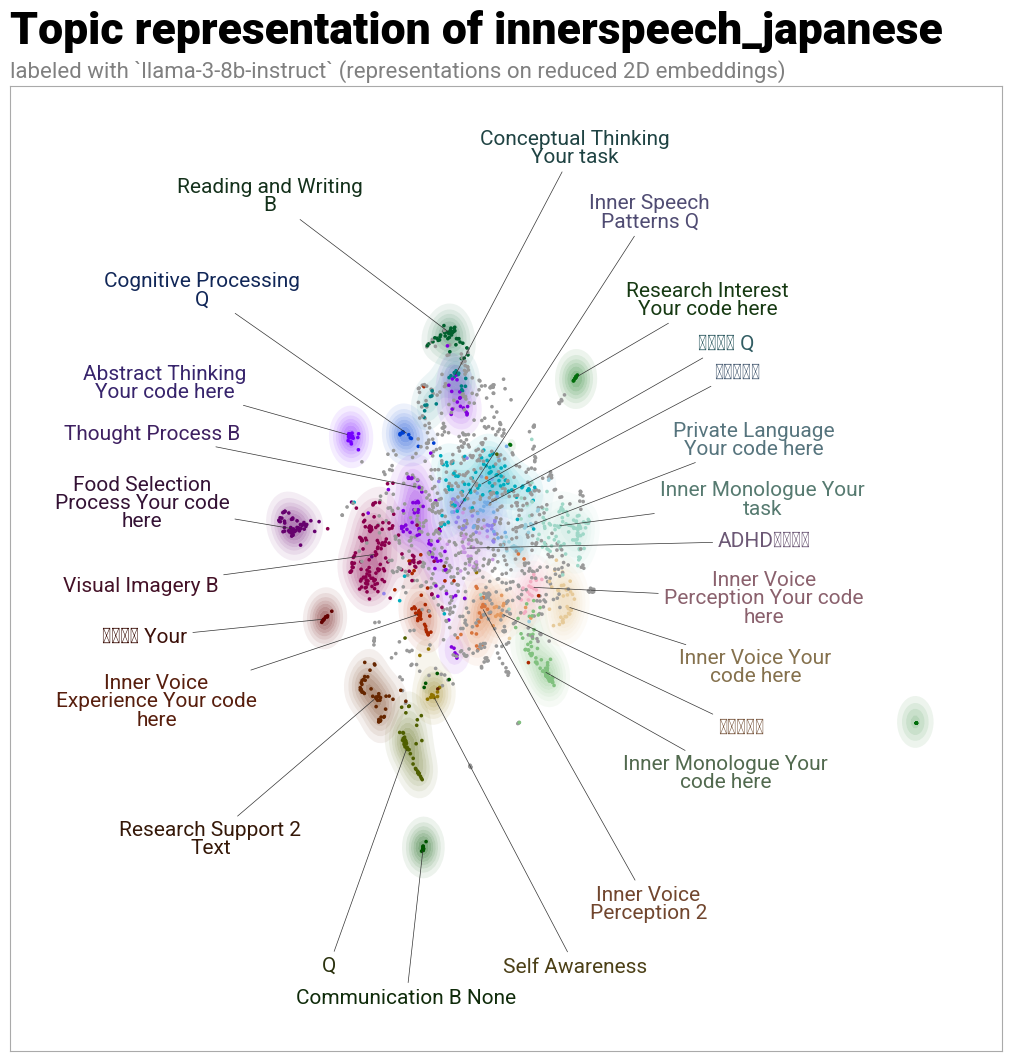

In [ ]:

# check if we have cached labels previously saved
llama_labels_path = os.path.join(cache_dir, f"{dataset}_llama_labels.pkl")
if os.path.exists(llama_labels_path):
    print("Loading cached LLM labels...")
    with open(llama_labels_path, "rb") as f:
        topic_labels = pickle.load(f)
    print("Loaded previously cached LLM labels.")

else:
    from huggingface_hub import hf_hub_download
    from llama_cpp import Llama
    from bertopic.representation import LlamaCPP
    import re
    
    print("Loading LLM model for topic labeling...")
    
    model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
    model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
    model_cache_dir = os.path.join('models', f"{model_name_or_path.replace('/', '_')}")  # Cache directory for the model
    
    #check if model exists already in cache
    model_path = os.path.join(model_cache_dir, model_basename)
    if os.path.exists(model_path):
        print("Model already downloaded. Using cached model...")
    else:
        # download model
        print("Downloading LLM...")
        os.makedirs(model_cache_dir, exist_ok=True)        
        model_path = hf_hub_download(
            repo_id=model_name_or_path, 
            filename=model_basename, 
            cache_dir=model_cache_dir
        )
    
    # Load the model
    llm = Llama(
        model_path=model_path, 
        n_gpu_layers=-1, 
        n_ctx=4096, 
        stop=["Q:", "\n"],
        verbose=False
    )
    
    
    # # Create prompt for LLama
    # prompt = """Q:
    # Topic documents:
    # [DOCUMENTS]
    
    # Topic keywords: '[KEYWORDS]'
    
    # Find the most appropriate scientific label for this topic based on the above information. The label should:
    
    # 1. Uses Title Case with proper spacing
    # 2. Avoids abstract interpretations
    # 3. Be concise yet comprehensive (2-5 words max)
    
    # Only return the label itself, without any additional text, punctuation, or prefix.
    # A:
    # """

    # Create prompt for LLama
    # prompt = """Q:
    # Below are examples of text that belong to a single topic. I need you to create a short, clear label that captures what this topic is about.

    # Text examples:
    # [DOCUMENTS]
    
    # Frequent words in this topic: '[KEYWORDS]'
    
    # Create a concise label that describes this topic. The label should:
    # 1. Be specific and informative
    # 2. Avoid very generic terms 
    # 3. Focus on the actual content/subject matter
    # 4. Be in Title Case
    
    # The label should NOT:
    # 1. Include letters like "B" or "C" or any other unexplained abbreviations
    # 2. Be cut off or incomplete
    
    # Return ONLY the label without any explanation or prefix.
    # A:
    # """
    prompt = """Q:
    Below are examples of text that belong to a single topic. The frequent words in this topic are: '[KEYWORDS]'

    Examples:
    [DOCUMENTS]

    Your task: Provide ONLY a concise 2-5 word title for this topic in Title Case.

    Do NOT include any of the following in your response:
    - The word "Answer"
    - The phrase "The topic is about"
    - Any explanatory text
    - Any prefixes or suffixes

    Just return the clean topic label itself.
    A:
    """

    # Generate labels using LLama
    topic_labels = {}
    topics_to_label = topic_info['Topic'].tolist()
    
    for topic_id in topics_to_label:
        # Get topic keywords and documents
        keywords = ", ".join([word for word, _ in base_topic_model.get_topic(topic_id)])
        topic_docs = [processed_data[i] for i, t in enumerate(topics) if t == topic_id][:6]  # Use up to 6 docs
        
        # Format prompt
        topic_prompt = prompt.replace("[KEYWORDS]", keywords).replace("[DOCUMENTS]", "\n".join(topic_docs))
        
        # Get LLama response
        llm_response = llm(topic_prompt, max_tokens=10, temperature=0.0, top_p=0.1, repeat_penalty=1.5)
        label = llm_response["choices"][0]["text"].strip()

        
        # Clean up the label
        label = re.sub(r'\W+', ' ', label).strip()
        if not label:
            label = f"Topic {topic_id}"
            
        topic_labels[topic_id] = label
        print(f"Topic {topic_id}: {label}")
    
    # Save the labels
    with open(llama_labels_path, "wb") as f:
        pickle.dump(topic_labels, f)
        
# Set the labels
base_topic_model.set_topic_labels(topic_labels)

# Visualize with LLama labels
llama_vis = base_topic_model.visualize_documents(
    docs=processed_data,
    reduced_embeddings=reduced_embeddings,
    title=f"Documents and Topics for {dataset} (LLama Labels)",
    hide_annotations=True, 
    hide_document_hover=False, 
    custom_labels=True
)

# Additional visualization with DataMapPlot if available
try:
    import datamapplot
    import torch
    torch.cuda.empty_cache()
    
    # Prepare labels for all documents
    all_labels = [topic_labels.get(t, "Unlabelled") if t != -1 else "Unlabelled" for t in topics]
    
    # Create plot
    datamapplot.create_plot(
        reduced_embeddings,
        all_labels,
        label_font_size=15,
        title=f"Topic representation of {dataset}",
        sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
        label_wrap_width=20,
        use_medoids=True
    )
except (ImportError, Exception) as e:
    print(f"DataMapPlot visualization skipped: {str(e)}")
    
except (ImportError, Exception) as e:
    print(f"LLama integration skipped: {str(e)}")
    print("Continuing with base model results only.")

print("Topic modeling pipeline completed.")

Topic -1: 「思考の迷宮」 B:
Topic 0: 映像の世界 B:
Topic 1: 「内言の世界」 B:
Topic 2: 自動思考 B: C:
Topic 3: ひとりごとの内言
Topic 4: 「思考の二重」 B:
Topic 5: 写真を食べたいもの B:
Topic 6: 研究応援 B: とても
Topic 7: 「小説の書き方」
Topic 8: 「アンケート結果」 B:
Topic 9: ADHDと音楽 B:
Topic 10: 「内言の世界」 B:
Topic 11: 内言の現れ方
Topic 12: 「内言の意義」
Topic 13: ADHD薬の影響 B:
Topic 14: 「内言の自覚」
Topic 15: 面白い研究 B:
Topic 16: 「内言の特徴」
Topic 17: 「抽象思考の特徴
Topic 18: 「哲学的な思考」 B:
Topic 19: 複数人いる 読んでいる間
Topic 20: 「内言の流れ」
Topic 21: 内言の声 B:
Topic 22: 「痛覚と共感」
Topic 23: 内言の世界 B:
Topic 24: 夜の夢 B:
Topic 25: 五感の内言 B:


Calculating medoids: 100%|██████████| 25/25 [00:00<00:00, 2218.46it/s]


Topic modeling pipeline completed.


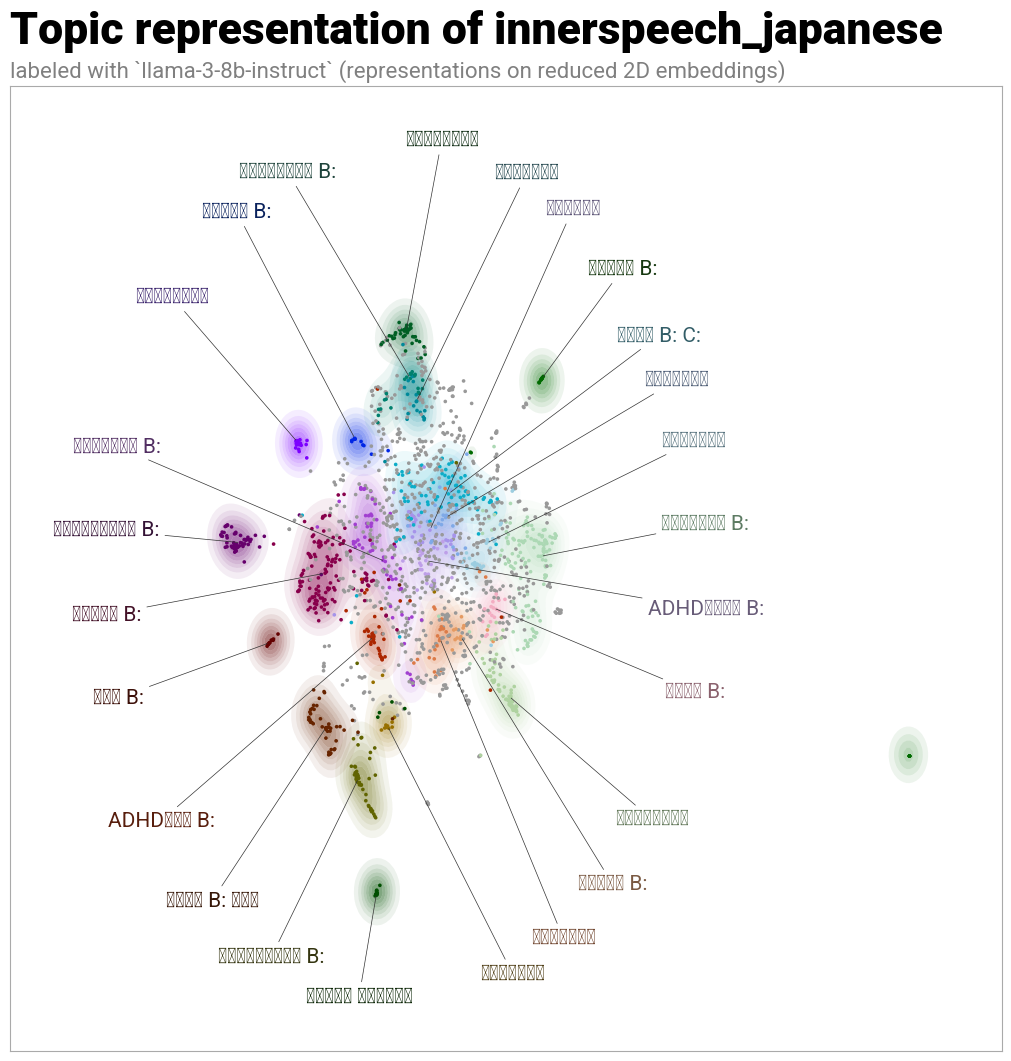

In [29]:
# Delete the cached LLM labels
delete_LLM_cache = True
if delete_LLM_cache and os.path.exists(llama_labels_path):
    os.remove(llama_labels_path)
    print(f"Deleted cached LLM labels: {llama_labels_path}")

# Japanese prompt for better results with Japanese corpus
prompt = """Q:
以下は同じトピックに属するテキストの例です。このトピックの頻出単語は: '[KEYWORDS]'

例:
[DOCUMENTS]

あなたの任務: このトピックを2〜5語の日本語の簡潔なタイトルで表してください。

以下を含めないこと:
- 「回答」という単語
- 「トピックは〜について」という表現
- 説明的なテキスト
- 前置きや接尾辞

タイトルだけをシンプルに返してください。
A:
"""

# Generate labels using LLama
topic_labels = {}
topics_to_label = topic_info['Topic'].tolist()

for topic_id in topics_to_label:
    # Get topic keywords and documents
    keywords = ", ".join([word for word, _ in base_topic_model.get_topic(topic_id)])
    topic_docs = [processed_data[i] for i, t in enumerate(topics) if t == topic_id][:6]
    
    # Format prompt
    topic_prompt = prompt.replace("[KEYWORDS]", keywords).replace("[DOCUMENTS]", "\n".join(topic_docs))
    
    # Get LLama response with stricter parameters
    llm_response = llm(topic_prompt, max_tokens=8, temperature=0.0, top_p=0.05, repeat_penalty=1.8)
    label = llm_response["choices"][0]["text"].strip()
    
    # Comprehensive cleanup
    # Remove artifacts and instructions that leaked into the response
    artifacts = [
        r'\bYour (code|task)\b.*$', 
        r'\bA\b$', 
        r'\bB\b$', 
        r'\bQ\b$',
        r'^\w\s',  # Single letter followed by space at beginning
        r'\s\w$'   # Single letter at the end
    ]
    
    # Apply all the cleanup patterns
    for pattern in artifacts:
        label = re.sub(pattern, '', label, flags=re.IGNORECASE)
    
    # Also remove common prefixes
    prefix_patterns = [
        r'^Answer:?\s*',
        r'^The topic (is|seems to be) about\s*',
        r'^This topic (is|seems to be) about\s*',
        r'^Topic:?\s*',
        r'^Label:?\s*',
    ]
    
    for pattern in prefix_patterns:
        label = re.sub(pattern, '', label, flags=re.IGNORECASE)
    
    # Final cleanup of multiple spaces, etc.
    label = re.sub(r'\s+', ' ', label).strip()
    
    if not label:
        label = f"トピック {topic_id}"
        
    topic_labels[topic_id] = label
    print(f"Topic {topic_id}: {label}")

# Save the labels
with open(llama_labels_path, "wb") as f:
    pickle.dump(topic_labels, f)

    
# Set the labels
base_topic_model.set_topic_labels(topic_labels)

# Visualize with LLama labels
llama_vis = base_topic_model.visualize_documents(
    docs=processed_data,
    reduced_embeddings=reduced_embeddings,
    title=f"Documents and Topics for {dataset} (LLama Labels)",
    hide_annotations=True, 
    hide_document_hover=False, 
    custom_labels=True
)

# Additional visualization with DataMapPlot if available
try:
    import datamapplot
    import torch
    torch.cuda.empty_cache()
    
    # Prepare labels for all documents
    all_labels = [topic_labels.get(t, "Unlabelled") if t != -1 else "Unlabelled" for t in topics]
    
    # Create plot
    datamapplot.create_plot(
        reduced_embeddings,
        all_labels,
        label_font_size=15,
        title=f"Topic representation of {dataset}",
        sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
        label_wrap_width=20,
        use_medoids=True
    )
except (ImportError, Exception) as e:
    print(f"DataMapPlot visualization skipped: {str(e)}")
    
except (ImportError, Exception) as e:
    print(f"LLama integration skipped: {str(e)}")
    print("Continuing with base model results only.")

print("Topic modeling pipeline completed.")